# Advanced First-Order Second-Moment Methods

Created by Michael J. Quevillon (mquevill@nd.edu)
2020-07-07

The following text, example, and code were adapted from:

McClarren, Ryan G (2018). *Uncertainty Quantification and Predictive Computational Science: A Foundation for Physical Scientists and Engineers*, *Chapter 8: Reliability Methods for Estimating the Probability of Failure*, Springer, https://doi.org/10.1007/978-3-319-99525-0_8

In [1]:
# Import libraries
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import gumbel_r, norm

In [2]:
# Download figures
import os, requests, urllib

# GitHub pages url
url = "https://ndcbe.github.io/cbe67701-uncertainty-quantification/"

# relative file paths to download
# this is the only line of code you need to change
file_paths = ['figures/Fig-8.6.png', 'figures/Fig-8.7.png']

# loop over all files to download
for file_path in file_paths:
    print("Checking for",file_path)
    # split each file_path into a folder and filename
    stem, filename = os.path.split(file_path)
    
    # check if the folder name is not empty
    if stem:
        # check if the folder exists
        if not os.path.exists(stem):
            print("\tCreating folder",stem)
            # if the folder does not exist, create it
            os.mkdir(stem)
    # if the file does not exist, create it by downloading from GitHub pages
    if not os.path.isfile(file_path):
        file_url = urllib.parse.urljoin(url,
                urllib.request.pathname2url(file_path))
        print("\tDownloading",file_url)
        with open(file_path, 'wb') as f:
            f.write(requests.get(file_url).content)
    else:
        print("\tFile found!")

Checking for figures/Fig-8.6.png
	File found!
Checking for figures/Fig-8.7.png
	File found!


## Advanced FOSM

FOSM is independent of the underlying distributions. As we have learned, two distributions can have the same mean and variance and still be wildly different in their overall distributions. Advanced FOSMs *try* to incorporate the true underlying distributions.

### Example QoI

$Q(\mathbf{x}) = 2 x_1^3 + 10 x_1 x_2 + x_1 + 3 x_2^2 + x_1$

In [3]:
def checksize2(x):
    if np.array(x).shape[-1] != 2:
        raise IndexError("Input to Q(x) must have a shape ending with 2.")

def Q(x):
    checksize2(x)
    x1, x2 = x[...,0], x[...,1]
    return 2*x1**3 + 10*x1*x2 + x1 + 3*x2**3 + x2

def delxQ(x):
    checksize2(x)
    x1, x2 = x[...,0], x[...,1]
    return np.array([
        6*x1**2 + 10*x2 + 1,
        10*x1 + 9*x2**2 + 1
    ])

def y(x, mean, var):
    checksize2(x)
    checksize2(mean)
    checksize2(var)
    return np.divide(x - mean, var)

def x(y, mean, var):
    checksize2(y)
    checksize2(mean)
    checksize2(var)
    return np.multiply(y, var) + mean
    
# y = (x-mean)/var
# dx/dy = var
# dely is just var*delx
def delyQ(x, var):
    checksize2(var)
    return np.multiply(delxQ(x), var)
    

In [20]:
# Add a failure surface to current plot
def fail_surface(Qfail, ax=None, **plt_kwargs):
    if ax is None:
        ax = plt.gca()
    x1 = ax.get_xlim()
    x2 = ax.get_ylim()
    N = 100 # grid points
    X, Y = np.meshgrid(
        np.linspace(x1[0], x1[1], N),
        np.linspace(x2[0], x2[1], N)
    )
    Z = Q(np.dstack((X, Y)))
    ax.contour(X, Y, Z, [Qfail], colors="k", linewidths=2, **plt_kwargs)
    return ax

In [28]:
# Add a beta contour to current plot
def beta_contour(betas, mean, var, ax=None, **plt_kwargs):
    if ax is None:
        ax = plt.gca()
    x1 = ax.get_xlim()
    x2 = ax.get_ylim()
    N = 100 # grid points
    X, Y = np.meshgrid(
        np.linspace(x1[0], x1[1], N),
        np.linspace(x2[0], x2[1], N)
    )
    yp = y(np.dstack((X, Y)), mean, var)
    Z = 
    Z = yp.T @ np.linalg.inv(R) @ yp
    ax.contour(X, Y, Z, betas**2)
    return ax

### Example for Figure 8.6

This example shows AFOSM with two variables that have a multivariate normal distribution. The off-diagonal terms in the covariance and correlation matrices indicate that these variables are **not** independent!

In [29]:
# values from the book
mean = np.array([0.1, -0.05]) 
sigma = np.array([[4, 3.9],[3.9, 9]])
var = np.sqrt(np.diagonal(sigma))
R = np.array([[1, 0.65],[0.65, 1]])
Qfail = 100

tol = 1e-6
delta = tol
eps = tol

In [30]:
def AFOSM_gaussian(x0, iters=25):
    xcurr = np.array(x0)
    betacurr = 1000 # arbitrarily large value

    betas = np.empty(iters+1)
    betas[:] = np.nan
    betas[0] = betacurr
    X = np.empty((2, iters+1))
    X[:] = np.nan
    X[:, 0] = xcurr

    isConverged = False
    for l in range(iters):
        ycurr = y(xcurr, mean, var)
        dyQ = delyQ(xcurr, var)
        lamb = (Qfail - Q(xcurr) + dyQ @ ycurr)/(dyQ @ R @ np.transpose(dyQ))
        ynext = lamb * R @ np.transpose(dyQ)
        betanext = np.sqrt(np.transpose(ynext) @ np.linalg.inv(R) @ ynext)
        xnext = x(ynext, mean, var)
        if np.abs(betanext - betacurr) < delta and np.abs(Q(xnext) - Qfail) < eps:
            isConverged = True
            break
        betacurr = betanext
        xcurr = xnext
        X[:, l+1] = xnext
        betas[l+1] = betanext
        beta_contours(betanext, mean, var)

    if not isConverged:
        print(f"AFOSM did not converge in {iters} iterations!")

    X = X[:,~np.isnan(X).any(axis=0)]
    betas = betas[~np.isnan(betas)]
    return X, betas

Using all of these functions we have defined, we can then just put an initial guess into this to recreate the figures from the book.

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 100)

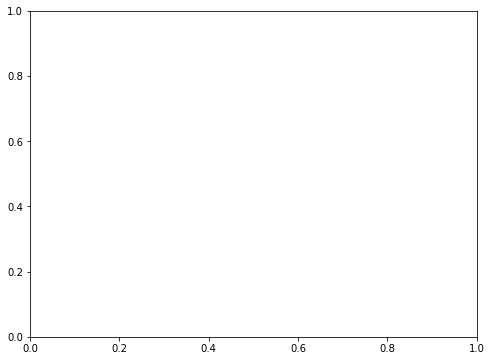

In [31]:
plt.figure(figsize=(8,6))
xred, bred = AFOSM_gaussian([-4, 5])
plt.plot( xred[0,:],  xred[1,:], marker="o", color="r")
xblue, bblue = AFOSM_gaussian([3, 0])
plt.plot(xblue[0,:], xblue[1,:], marker="o", color="b")
plt.xlim([-4.5,4.5]); plt.ylim([-4,6])
fail_surface(Qfail)
beta_contours(bred)
plt.show()

The following is Figure 8.6 from McClarren (2018):

![Figure 8.6](figures/Fig-8.6.png)

This is a relatively simple story, but there's more to this story...

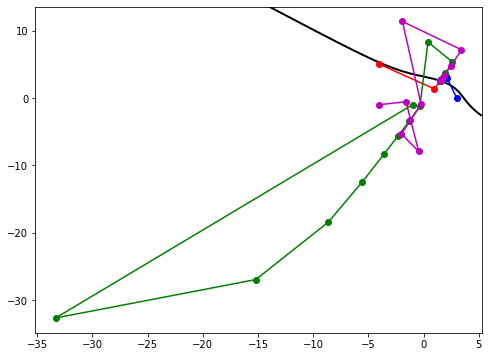

In [22]:
plt.figure(figsize=(8,6))
xred, _ = AFOSM_gaussian([-4, 5])
plt.plot( xred[0,:],  xred[1,:], marker="o", color="r")
xblue, _ = AFOSM_gaussian([3, 0])
plt.plot(xblue[0,:], xblue[1,:], marker="o", color="b")
xgreen, _ = AFOSM_gaussian([-1,-1])
plt.plot(xgreen[0,:], xgreen[1,:], marker="o", color="g")
xpurple, _ = AFOSM_gaussian([-4,-1])
plt.plot(xpurple[0,:], xpurple[1,:], marker="o", color="m")
fail_surface(Qfail)
plt.show()

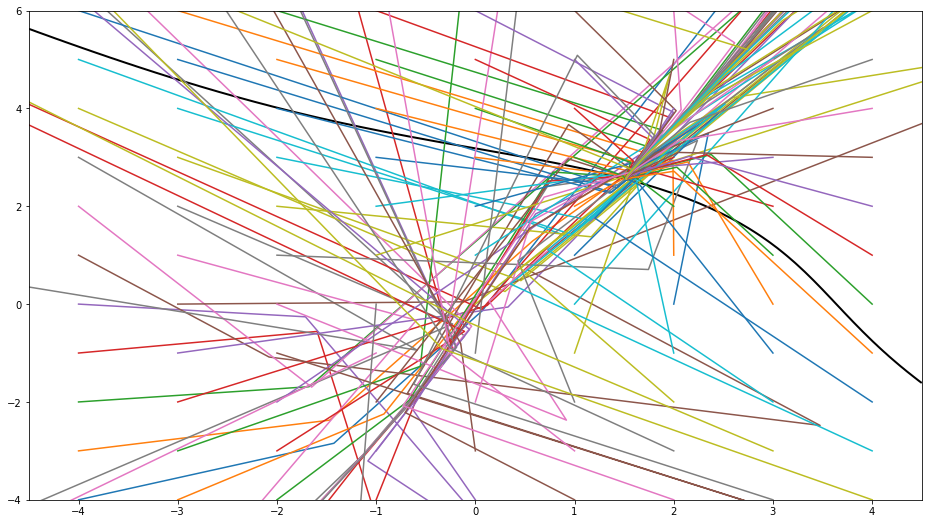

In [23]:
import itertools

lx = np.linspace(-4, 4, 9)
ly = np.linspace(-4, 6, 11)
# lx = [-4]
# ly = [1]
plt.figure(figsize=(16,9))
for pt in itertools.product(lx, ly):
    X, b = AFOSM_gaussian(pt)
#     plt.plot(X[0,-1], X[1,-1], marker="o")
    plt.plot(X[0,:], X[1,:])
plt.xlim([-4.5,4.5]); plt.ylim([-4,6])
fail_surface(Qfail)
plt.show()

Using basic FOSM, we get that the probability of failure is functionally zero, because the estimate of beta from Eq. (8.5) (basic FOSM) is 14.6.

Since the point of interest has $Q << Q_{fail}$, AFOSM is necessary to determine the point of failure.

### Gumbel Distribution

In [ ]:
N = 5000
gumbel = gumbel_r.rvs(size=N)
xg = np.linspace(np.amin(gumbel), np.amax(gumbel), 100)
yg = gumbel_r.pdf(xg)
plt.hist(gumbel, bins=50, density=True)
plt.plot(xg, yg, color="k")
plt.xlabel("x")
plt.ylabel("Gumbel distribution")
plt.show()

### Example for Figure 8.7

This example shows AFOSM with two independent variables that each have a Gumbel distribution.

**NOT CURRENTLY WORKING**

In [ ]:
# All other input parameters are kept the same
R = np.array([[1, 0],[0, 1]]) # completely independent!

In [ ]:
def gumbel_std(x, mean):
    var = np.empty(2)
    for i,_ in enumerate(x):
        var[i] = norm.pdf(norm.ppf(gumbel_r.cdf(x[i], loc=mean[i]), loc=mean[i]), loc=mean[i])/gumbel_r.pdf(x[i], loc=mean[i])
    return var

In [ ]:
def AFOSM_gumbel(x0, iters=100):
    xcurr = np.array(x0)
    betacurr = 1000 # arbitrarily large value

    betas = np.empty(iters+1)
    betas[:] = np.nan
    betas[0] = betacurr
    X = np.empty((2, iters+1))
    X[:] = np.nan
    X[:, 0] = xcurr

    isConverged = False
    for l in range(iters):
        mean_g = gumbel_r.median(loc=mean)
        var_g = gumbel_std(xcurr, mean_g)
        ycurr = y(xcurr, mean_g, var_g)
        dyQ = delyQ(xcurr, var_g)
        lamb = (Qfail - Q(xcurr) + dyQ @ ycurr)/(dyQ @ R @ np.transpose(dyQ))
        ynext = lamb * R @ np.transpose(dyQ)
        betanext = np.sqrt(np.transpose(ynext) @ np.linalg.inv(R) @ ynext)
        xnext = x(ynext, mean_g, var_g)
        if np.abs(betanext - betacurr) < delta and np.abs(Q(xnext) - Qfail) < eps:
            isConverged = True
            break
        betacurr = betanext
        xcurr = xnext
        X[:, l+1] = xnext
        betas[l+1] = betanext

    if not isConverged:
        print(f"AFOSM did not converge in {iters} iterations!")

    X = X[:,~np.isnan(X).any(axis=0)]
    betas = betas[~np.isnan(betas)]
    return X, betas

In [ ]:
plt.figure(figsize=(8,5))
xred, betas = AFOSM_gumbel([-4, 5])
print(betas)
plt.plot( xred[0,:],  xred[1,:], marker="o", color="r")
xblue, _ = AFOSM_gumbel([3, 0])
plt.plot(xblue[0,:], xblue[1,:], marker="o", color="b")
plt.xlim([-4.5,4.5]); plt.ylim([-4,6])
fail_surface(Qfail)
plt.show()

The following is Figure 8.7 from McClarren (2018):

![Figure 8.7](figures/Fig-8.7.png)